# <u> Data analysis. Sant Vicenç dels Horts 2023. Escola La Guàrdia  </u>

<br>

## Session 1

<b> Place: </b> Escola La Guàrdia (Sant Vicenç dels Horts).

<b> Date and Time: </b> Thursday 14th September, 2023. From 9:00 pm to 11:00 pm.

Two sensors (FL and JP) collecting data in two different groups in the school playground (just to see how it works)

<br>
<br>


## INDEX

    0. Read and process the data-sets
    
    1. Sensor comparision
        1.1. Temperature statistics
        1.2. Quantiles map
        1.3. Heat-map of the trajectory
        
    
    
<br>
<br>

### Python libraries and functions

In [1]:
from gpxcsv import gpxtolist
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from folium import Map
from folium.plugins import HeatMap, HeatMapWithTime
import utm
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
from shapely.geometry import Point, LineString, Polygon
import folium
from math import sin, cos, sqrt, atan2, radians
import math
import time

import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
import shapely.plotting
from shapely.geometry import Polygon
import matplotlib as mpl
from matplotlib.cm import ScalarMappable


def plot_polygon(ax, poly, **kwargs):
    """ Function that plots a polygon given the axes of the figure, the polygon and the kwargs (color, etc).
    
    Input:
        - axes of figure
        - Polygon geometry
        - kwargs (facecolor, edgecolor, etc.)
    
    Ouput:
        - The polygon represented on the figure
        
    """
    
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection



def map_network_polygon(P):
    """" Function that creates a map of the urban network from OSM, from a polygon (using lat,lon coordenates)

    Input:
        - Polygon geometry
        
    Output:
        - The figure and the axes.
        
    """
    
    # Create the graph and the figure
    G = ox.graph_from_polygon(P, retain_all=True, simplify = True, network_type='all') 
    #G = ox.get_undirected(G)

    cm = 1/2.54
    a3=(42*cm, 29.7*cm)
    square=(91*cm, 91*cm)
    square2=(50*cm, 50*cm)
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="w",edge_color="#333333", edge_linewidth=0.6, 
                            edge_alpha=0.5, node_size=0, figsize=square)

    
    
    
    # 0. ALL BUILDINGS
    tags_buildings = {"building": True}
    gdf_buildings = ox.geometries.geometries_from_polygon(P, tags_buildings)
    gdf_buildings.plot(ax=ax,color='silver',alpha=0.3)
                                  
        
    # 0. TRAIN RAILS AND RIVERS
    tags_train = {"railway": "rail"}
    gdf_train = ox.geometries.geometries_from_polygon(P, tags_train)
    #gdf_train.plot(ax=ax,color='brown',alpha=0.8)  
    
    
    
    # 1. REST SPACES                            
    tags_rest_spaces = {"amenity": "bench",           # Bench, garden and park from OSM and fountain from Open Data Barceona
                      "leisure": ["garden","park"],
                       "water": "river"}
    
    gdf_rest_spaces = ox.geometries.geometries_from_polygon(P, tags_rest_spaces)
    if len(gdf_rest_spaces)!=0:
        gdf_rest_spaces.plot(ax=ax,color='green',alpha=0.4,markersize=100*cm)   
    
    place = "Hospitalet de Llobregat"  # Fountains from OSM in Hospitalet (in Barcelona OpenDataBcn)
    tags_fountains_hospi = {"amenity": ["drinking water", "fountain"]}  
    gdf_fountains_hospi = ox.geometries_from_place(place, tags_fountains_hospi)
    if len(gdf_fountains_hospi)!=0:
        gdf_fountains_hospi.plot(ax=ax, color='green', alpha=0.8,markersize=100*cm)
    
                     
        
    # 2. HEALTH
    tags_health = {"amenity": ["clinic", "dentist", "doctors", "hospital", "nursing_home", "pharmacy", "social_facility"]}
    gdf_health = ox.geometries.geometries_from_polygon(P, tags_health)
    if len(gdf_health)!=0:
        gdf_health.plot(ax=ax,color='blue',alpha=0.4,markersize=100*cm)
                                  
                                  
    # 3. EDUCATION
    tags_education = {"amenity": ["college", "kindergarten", "school", "university"]}                              
    gdf_education = ox.geometries.geometries_from_polygon(P, tags_education)
    if len(gdf_education)!=0:
        gdf_education.plot(ax=ax,color='cyan',alpha=0.4,markersize=100*cm)
                                  
                                  
    # 4. GATHERING SPACES
    tags_gathering = {"leisure": "playground",
                     "place": "square",
                     "highway": "pedestrian", "area":True}
    gdf_gathering = ox.geometries.geometries_from_polygon(P, tags_gathering)
    if len(gdf_gathering)!=0:
        gdf_gathering.plot(ax=ax,color='magenta',alpha=0.4,markersize=100*cm)
                                  
                                  
    # 5. TRANSPORT
    tags_transport = {"public_transport": ["stop_position", "platform", "station"],
                     "amenity": "bicycle_parking"}
    gdf_transport = ox.geometries.geometries_from_polygon(P, tags_transport)
    if len(gdf_transport)!=0:
        gdf_transport.plot(ax=ax,color='purple',alpha=0.4,markersize=100*cm)
                                  
                                  
    # 6. SPORTS EQUIPMENTS
    tags_esports = {"leisure": ["fitness_centre", "fitness_station", "pitch", "sports_centre", "swimming_pool", "track"]}
    gdf_esports = ox.geometries.geometries_from_polygon(P, tags_esports)
    if len(gdf_esports)!=0:
        gdf_esports.plot(ax=ax,color='red',alpha=0.4,markersize=100*cm)
                                  
                                  
    # 7. BASICS PURCHASE
    tags_purchase = {"amenity": "market_place"}                              
    gdf_purchase = ox.geometries.geometries_from_polygon(P, tags_purchase)
    if len(gdf_purchase)!=0:
        gdf_purchase.plot(ax=ax,color='black',alpha=0.5,markersize=100*cm)
                                  
                                  
    # 8. CULTURAL EQUIPMENTS
    tags_cultural = {"amenity": ["community_centre", "library", "culture_centre"],
                    "building": "museum"}
    gdf_cultural = ox.geometries.geometries_from_polygon(P, tags_cultural)
    if len(gdf_cultural)!=0:
        gdf_cultural.plot(ax=ax,color='gold',alpha=0.4,markersize=100*cm)
                                  
                
    return fig, ax


def quantiles(df):
    """ This function returns the temperatures and the coordinates (latitude and longitudes) of those records with a temperature
        below the first quantile (Q1, 25%) and above the third quantile (Q3, 75%)
        
    Inputs:
        - Dataframe with the temperature and latitude and longitude columns
    
    Outputs:
        - Lists of temperatures and latitudes and longitudes of the first and third quantiles
    """
    
    temp = df['Temp[°C]'].tolist()
    lat = df['Lat'].tolist()
    lon = df['Lon'].tolist()
    
    q1 = np.quantile(temp,0.05)
    q2 = np.quantile(temp,0.5)
    q3 = np.quantile(temp,0.95)
    
    temp_q1=[]
    temp_q3=[]
    lat_q1=[]
    lon_q1=[]
    lat_q3=[]
    lon_q3=[]
    
    for i in range(len(temp)):
        if temp[i]<=q1:
            temp_q1.append(temp[i])
            lat_q1.append(lat[i])
            lon_q1.append(lon[i])
            
        if temp[i]>=q3:
            temp_q3.append(temp[i])
            lat_q3.append(lat[i])
            lon_q3.append(lon[i])
     
    print('The average temperature is {:.1f}ºC'.format(np.mean(temp)))
    print('The minimum temperature is {:.1f}ºC and the maximum {:.1f}ºC'.format(min(temp),max(temp)))
    print('The quantiles are:')
    print('Q1(5%) = {:.1f}ºC'.format(q1))
    print('Q2(50%) = {:.1f}ºC'.format(q2))     
    print('Q3(95%) = {:.1f}ºC'.format(q3))
    print('---------------------------------------------')
    print('')
    
    return temp_q1,temp_q3,lat_q1,lon_q1,lat_q3, lon_q3

#### Drinking fountains and ornamental fountains (OPEN DATA BCN)

We open the files containing the locations of the drinking and ornamental fountains in Barcelona (from OpenData Bcn)

In [2]:
df_fonts = pd.read_csv('C:\\Users\\josep\\OneDrive - Universitat de Barcelona\\Escritorio\\Cròniques_de_la_calor\\Data_layers_map\\fonts_beure_bcn_2023.csv')
df_fonts_ornamentals = pd.read_csv('C:\\Users\\josep\\OneDrive - Universitat de Barcelona\\Escritorio\\Cròniques_de_la_calor\\Data_layers_map\\fonts_ornamentals_bcn_2023.csv')

<br>
<br>


## <u> 0. Read and process the data-sets </u>


In [3]:
# Read csv files
df_stvicenç_sessio1_JP = pd.read_csv('Data//Original_data//original_guardia_JP_session1.csv')
df_stvicenç_sessio1_FL = pd.read_csv('Data//Original_data//original_guardia_FL_session1.csv')

# Correct datetime format of timestamp
df_stvicenç_sessio1_JP['Time'] = pd.to_datetime(df_stvicenç_sessio1_JP['Time'], format='%Y-%m-%dT%H:%M:%S%z') 
df_stvicenç_sessio1_FL['Time'] = pd.to_datetime(df_stvicenç_sessio1_FL['Time'], format='%Y-%m-%dT%H:%M:%S%z') 

print('The JP sensor has {} records and the FL sensor has {} records'.format(len(df_stvicenç_sessio1_JP), len(df_stvicenç_sessio1_FL)))
print('')

# Remove duplicated timestamps (and keep the first one recorded)
df_stvicenç_sessio1_JP.drop_duplicates(subset='Time', keep='first', inplace=True, ignore_index=True)
df_stvicenç_sessio1_FL.drop_duplicates(subset='Time', keep='first', inplace=True, ignore_index=True)


times_JP = df_stvicenç_sessio1_JP['Time'].tolist()
times_FL = df_stvicenç_sessio1_FL['Time'].tolist()

print('The sensor JP" starts at {} and ends at {}. With a total number of {} records.'.format(times_JP[0],
                                                                                                      times_JP[-1],
                                                                                                      len(times_JP)))
print('')

print('The sensor FL" starts at {} and ends at {}. With a total number of {} records.'.format(times_FL[0],
                                                                                                      times_FL[-1],
                                                                                                      len(times_FL)))

The JP sensor has 1166 records and the FL sensor has 1063 records

The sensor JP" starts at 2023-09-14 09:29:20+02:00 and ends at 2023-09-14 09:55:48+02:00. With a total number of 1160 records.

The sensor FL" starts at 2023-09-14 09:32:05+02:00 and ends at 2023-09-14 09:55:57+02:00. With a total number of 1063 records.


#### We remove the first 100 timestamps of both sensors, in order to guarantee that the sensors have been calibrated with the outside ambient temperature (and outside the classroom).

In [4]:
df_stvicenç_sessio1_JP = df_stvicenç_sessio1_JP[100:].reset_index()
del df_stvicenç_sessio1_JP['index']

df_stvicenç_sessio1_FL = df_stvicenç_sessio1_FL[100:].reset_index()
del df_stvicenç_sessio1_FL['index']


In [5]:
times_JP = df_stvicenç_sessio1_JP['Time'].tolist()
times_FL = df_stvicenç_sessio1_FL['Time'].tolist()

print('The sensor JP" starts at {} and ends at {}. With a total number of {} records.'.format(times_JP[0],
                                                                                                      times_JP[-1],
                                                                                                      len(times_JP)))
print('')

print('The sensor FL" starts at {} and ends at {}. With a total number of {} records.'.format(times_FL[0],
                                                                                                      times_FL[-1],
                                                                                                      len(times_FL)))

# Save processed csv files

#df_stvicenç_sessio1_JP.to_csv('Data//Processed_data//processed_guardia_JP_session1.csv',index=False)
#df_stvicenç_sessio1_FL.to_csv('Data//Processed_data//processed_guardia_FL_session1.csv',index=False)

The sensor JP" starts at 2023-09-14 09:31:29+02:00 and ends at 2023-09-14 09:55:48+02:00. With a total number of 1060 records.

The sensor FL" starts at 2023-09-14 09:34:16+02:00 and ends at 2023-09-14 09:55:57+02:00. With a total number of 963 records.


## <u> 1. Sensor comparision </u>

### 1.1. Temperature statistics

In [23]:
T_stvicenç_sessio1_JP = df_stvicenç_sessio1_JP['Temp[°C]'].tolist()
T_stvicenç_sessio1_FL = df_stvicenç_sessio1_FL['Temp[°C]'].tolist()

print('Sensor JP')
print('')
print('The number of collected temperatures is {}'.format(len(T_stvicenç_sessio1_JP)))
print('T min = {:.1f}ºC'.format(min(T_stvicenç_sessio1_JP)))
print('T max = {:.1f}ºC'.format(max(T_stvicenç_sessio1_JP)))
print('<T> = {:.1f}ºC'.format(np.mean(T_stvicenç_sessio1_JP)))
print('q1(25%) = {}ºC,  q2(50%) = {}ºC,  q3(75%) = {}ºC'.format(np.quantile(T_stvicenç_sessio1_JP,0.25),
                                                               np.quantile(T_stvicenç_sessio1_JP,0.50),
                                                               np.quantile(T_stvicenç_sessio1_JP,0.75)))
print('')
print('---------------')
print('')

print('Sensor FL')
print('')
print('The number of collected temperatures is {}'.format(len(T_stvicenç_sessio1_FL)))
print('T min = {:.1f}ºC'.format(min(T_stvicenç_sessio1_FL)))
print('T max = {:.1f}ºC'.format(max(T_stvicenç_sessio1_FL)))
print('<T> = {:.1f}ºC'.format(np.mean(T_stvicenç_sessio1_FL)))
print('q1(25%) = {}ºC,  q2(50%) = {}ºC,  q3(75%) = {}ºC'.format(np.quantile(T_stvicenç_sessio1_FL,0.25),
                                                               np.quantile(T_stvicenç_sessio1_FL,0.50),
                                                               np.quantile(T_stvicenç_sessio1_FL,0.75)))


Sensor JP

The number of collected temperatures is 1060
T min = 24.5ºC
T max = 26.3ºC
<T> = 25.1ºC
q1(25%) = 24.9ºC,  q2(50%) = 25.0ºC,  q3(75%) = 25.3ºC

---------------

Sensor FL

The number of collected temperatures is 963
T min = 24.4ºC
T max = 25.9ºC
<T> = 25.2ºC
q1(25%) = 24.9ºC,  q2(50%) = 25.2ºC,  q3(75%) = 25.3ºC


### 1.2. Quantiles map

In blue, we plot these temperatures in the first quantile <25%). In red, we plor these temperatures in the third quantile (>75%), using all the data records (from the two sensors and trajectories)

The average temperature is 25.1ºC
The minimum temperature is 24.5ºC and the maximum 26.3ºC
The quantiles are:
Q1(5%) = 24.7ºC
Q2(50%) = 25.0ºC
Q3(95%) = 25.7ºC
---------------------------------------------

The average temperature is 25.2ºC
The minimum temperature is 24.4ºC and the maximum 25.9ºC
The quantiles are:
Q1(5%) = 24.6ºC
Q2(50%) = 25.2ºC
Q3(95%) = 25.8ºC
---------------------------------------------



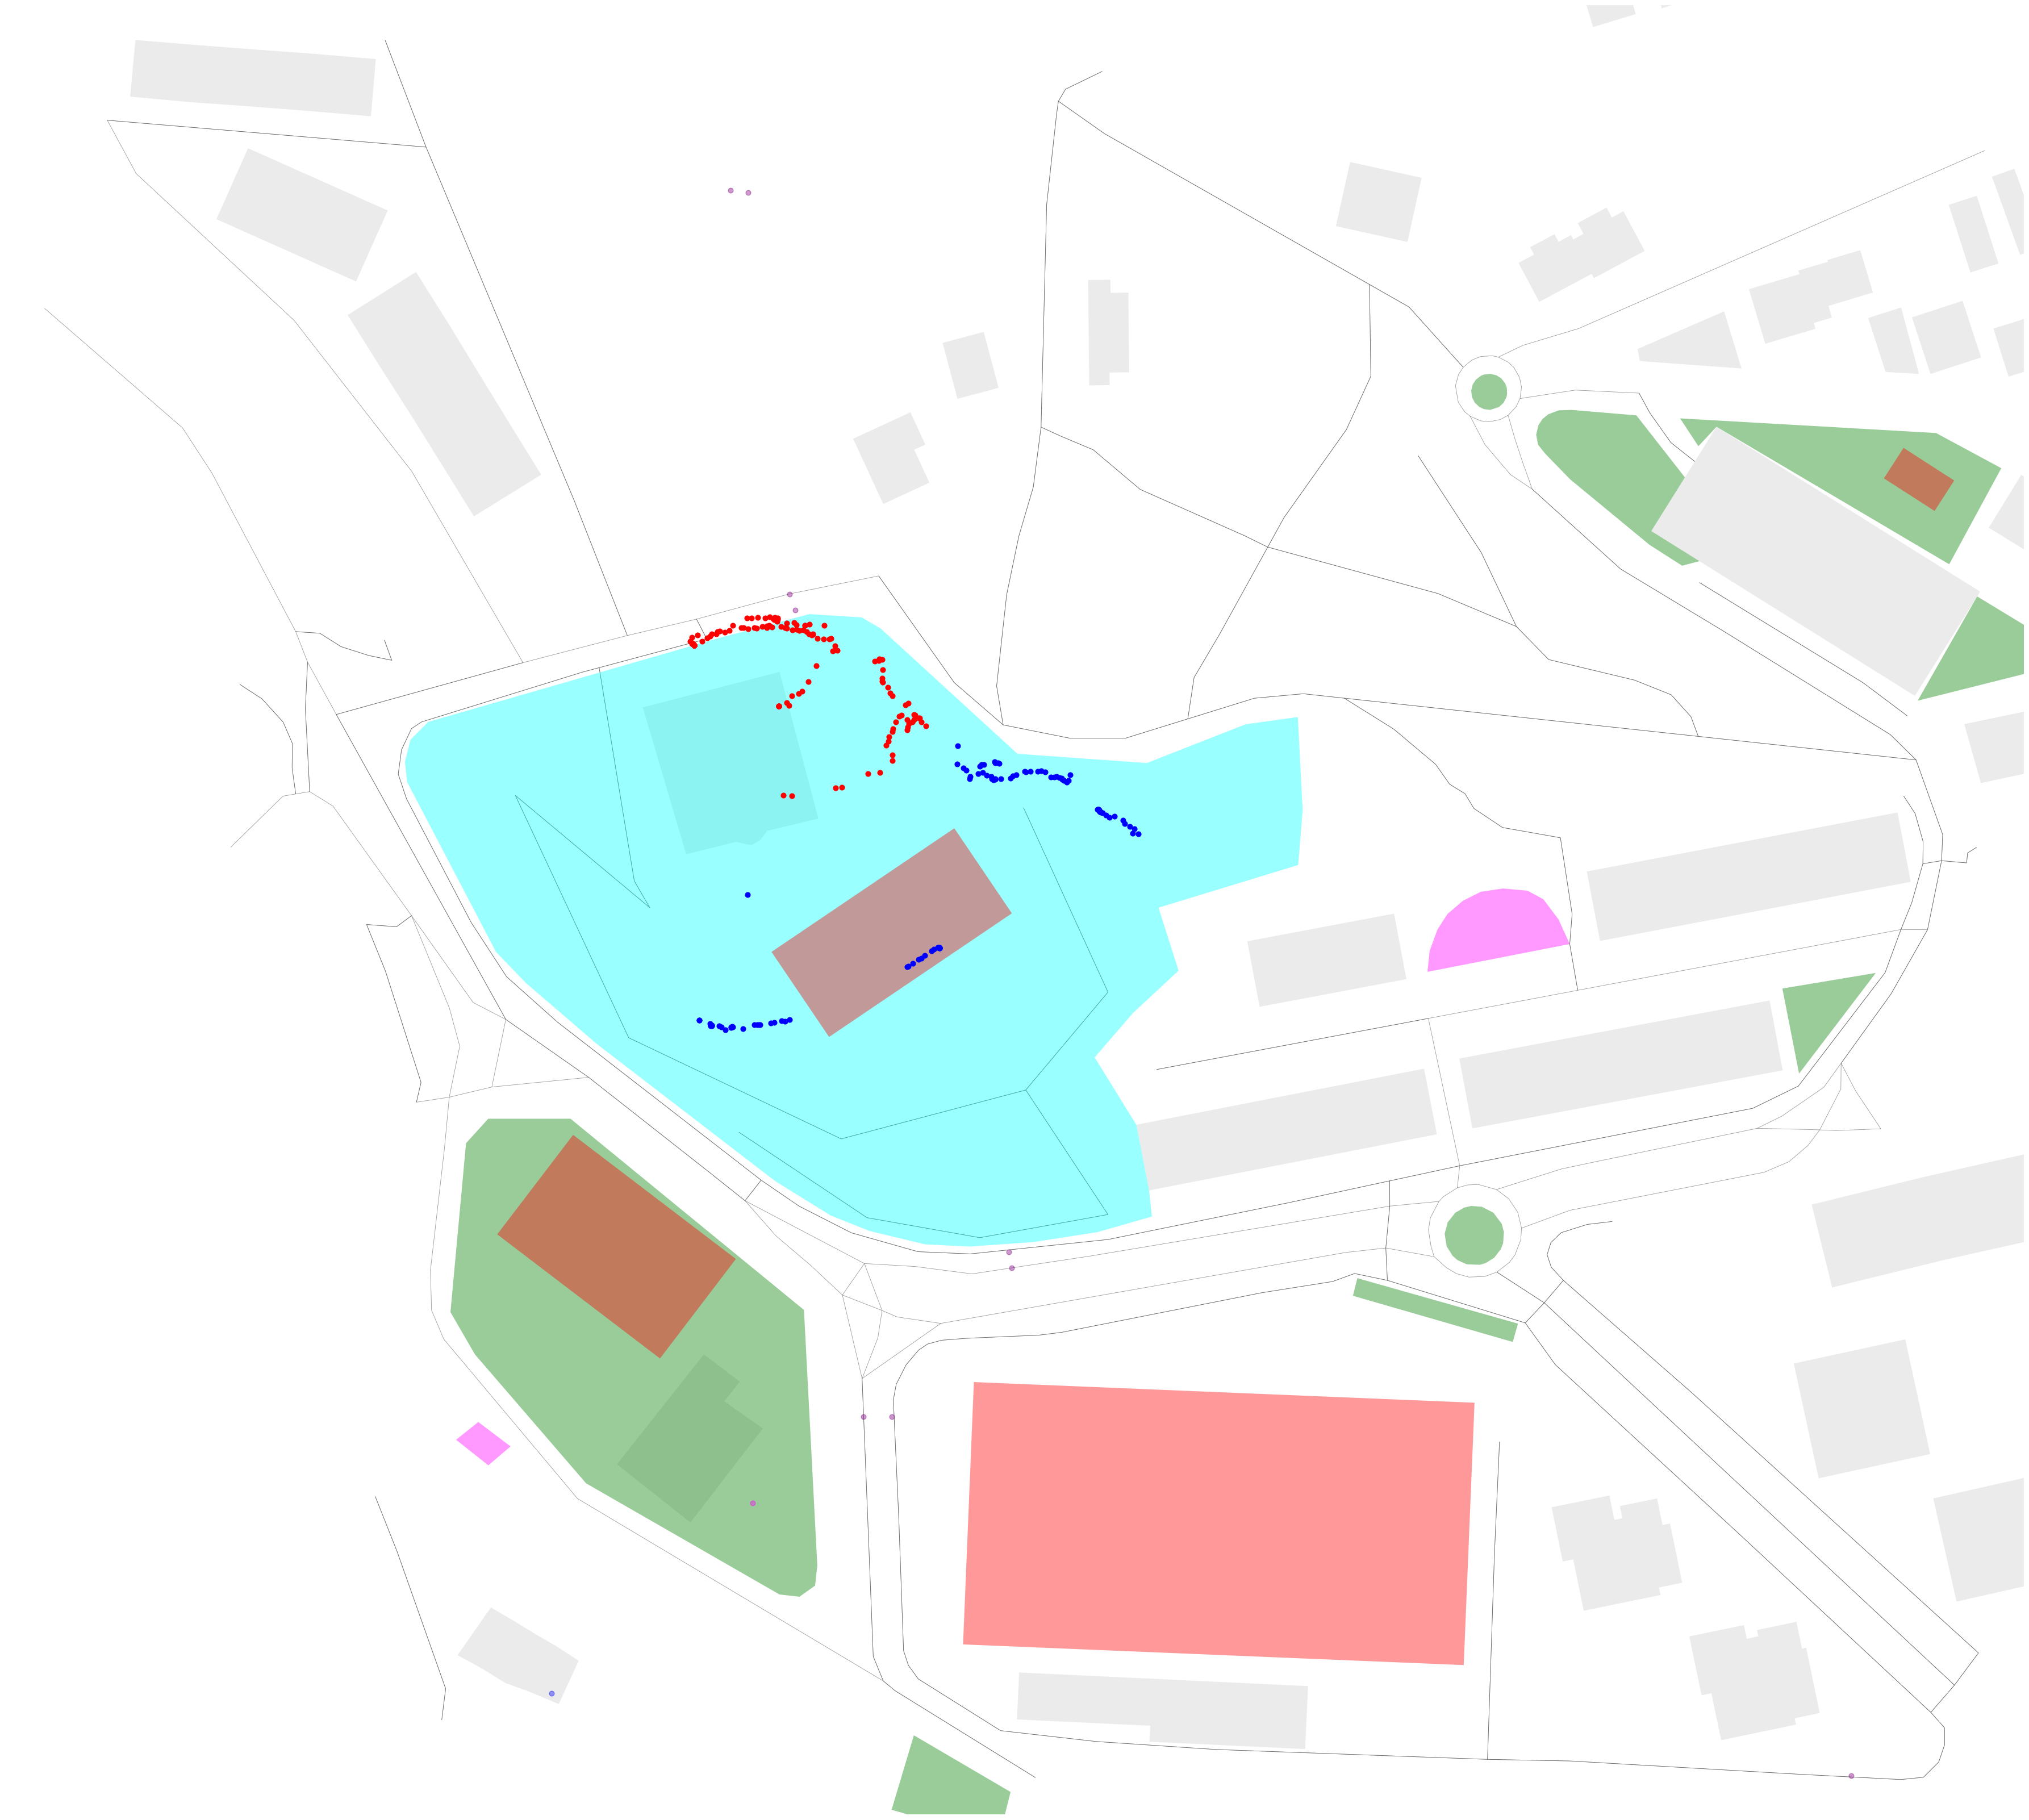

In [28]:
temp_q1_stvicenç_JP,temp_q3_stvicenç_JP,lat_q1_stvicenç_JP,lon_q1_stvicenç_JP,lat_q3_stvicenç_JP, lon_q3_stvicenç_JP = quantiles(df_stvicenç_sessio1_JP)
temp_q1_stvicenç_FL,temp_q3_stvicenç_FL,lat_q1_stvicenç_FL,lon_q1_stvicenç_FL,lat_q3_stvicenç_FL, lon_q3_stvicenç_FL = quantiles(df_stvicenç_sessio1_FL)


all_lat_q1_stvicenç = lat_q1_stvicenç_JP+lat_q1_stvicenç_FL
all_lon_q1_stvicenç = lon_q1_stvicenç_JP+lon_q1_stvicenç_FL
all_lat_q3_stvicenç = lat_q3_stvicenç_JP+lat_q3_stvicenç_FL
all_lon_q3_stvicenç = lon_q3_stvicenç_JP+lon_q3_stvicenç_FL


import matplotlib as mpl
from matplotlib.cm import ScalarMappable

# Create the Map around La Guàrdia School
#P = Polygon([(1.995034,41.397762), (2.012427,41.397541),(2.012673,41.385776),(1.994998,41.385952)])  # Create the graph from lat and lon bounds
P = Polygon([(2.0019857,41.3935882),(2.0020072,41.3903525),(2.0067279,41.3903847),(2.0067816,41.3936123),(2.0019857,41.3935882)])  # Create the graph from lat and lon bounds

fig, ax = map_network_polygon(P)


# Plot Escola La Guàrdia
polygon_guardia = Polygon([(2.003915506266272, 41.391737084994254), (2.0043995628384583, 41.39196168135994), 
                             (2.0039522518688724, 41.392496064170196), (2.003339341173576, 41.39238114470467)])


#plot_polygon(ax, polygon_guardia, facecolor='lightblue', edgecolor='black')

#bbox_args = dict(boxstyle='square',facecolor='white', edgecolor='k',alpha=0.8)
#plt.annotate('Escola La Guàrdia', (2.003915506266272, 41.391737084994254),c='black',size=20,
                 #bbox=bbox_args, xytext=(5, -10),textcoords='offset points')

cm = 1/2.54

ax.scatter(all_lon_q1_stvicenç,all_lat_q1_stvicenç, c='blue',s=100*cm)
ax.scatter(all_lon_q3_stvicenç,all_lat_q3_stvicenç, c='red',s=100*cm)

plt.tight_layout()

#plt.savefig('guardia_quantiles_map_sensors_session1.pdf',format='pdf')  # Save the figure in .pdf format

plt.show()


<br>
<br>

### 1.3. Heat-map of the trajectory

####  <u> JP SENSOR </u>

C:\Users\josep\AppData\Local\Temp\ipykernel_544\3453751909.py:31: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\Users\\josep\\OneDrive - Universitat de Barcelona\\Escritorio\\mapes_calor\\1_mapes_tallers\\logos_new.png'>
  im = plt.imread(get_sample_data('C:\\Users\\josep\\OneDrive - Universitat de Barcelona\\Escritorio\\mapes_calor\\1_mapes_tallers\\logos_new.png'))
C:\Users\josep\AppData\Local\Temp\ipykernel_544\3453751909.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('jet')
C:\Users\josep\AppData\Local\Temp\ipykernel_544\3453751909.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


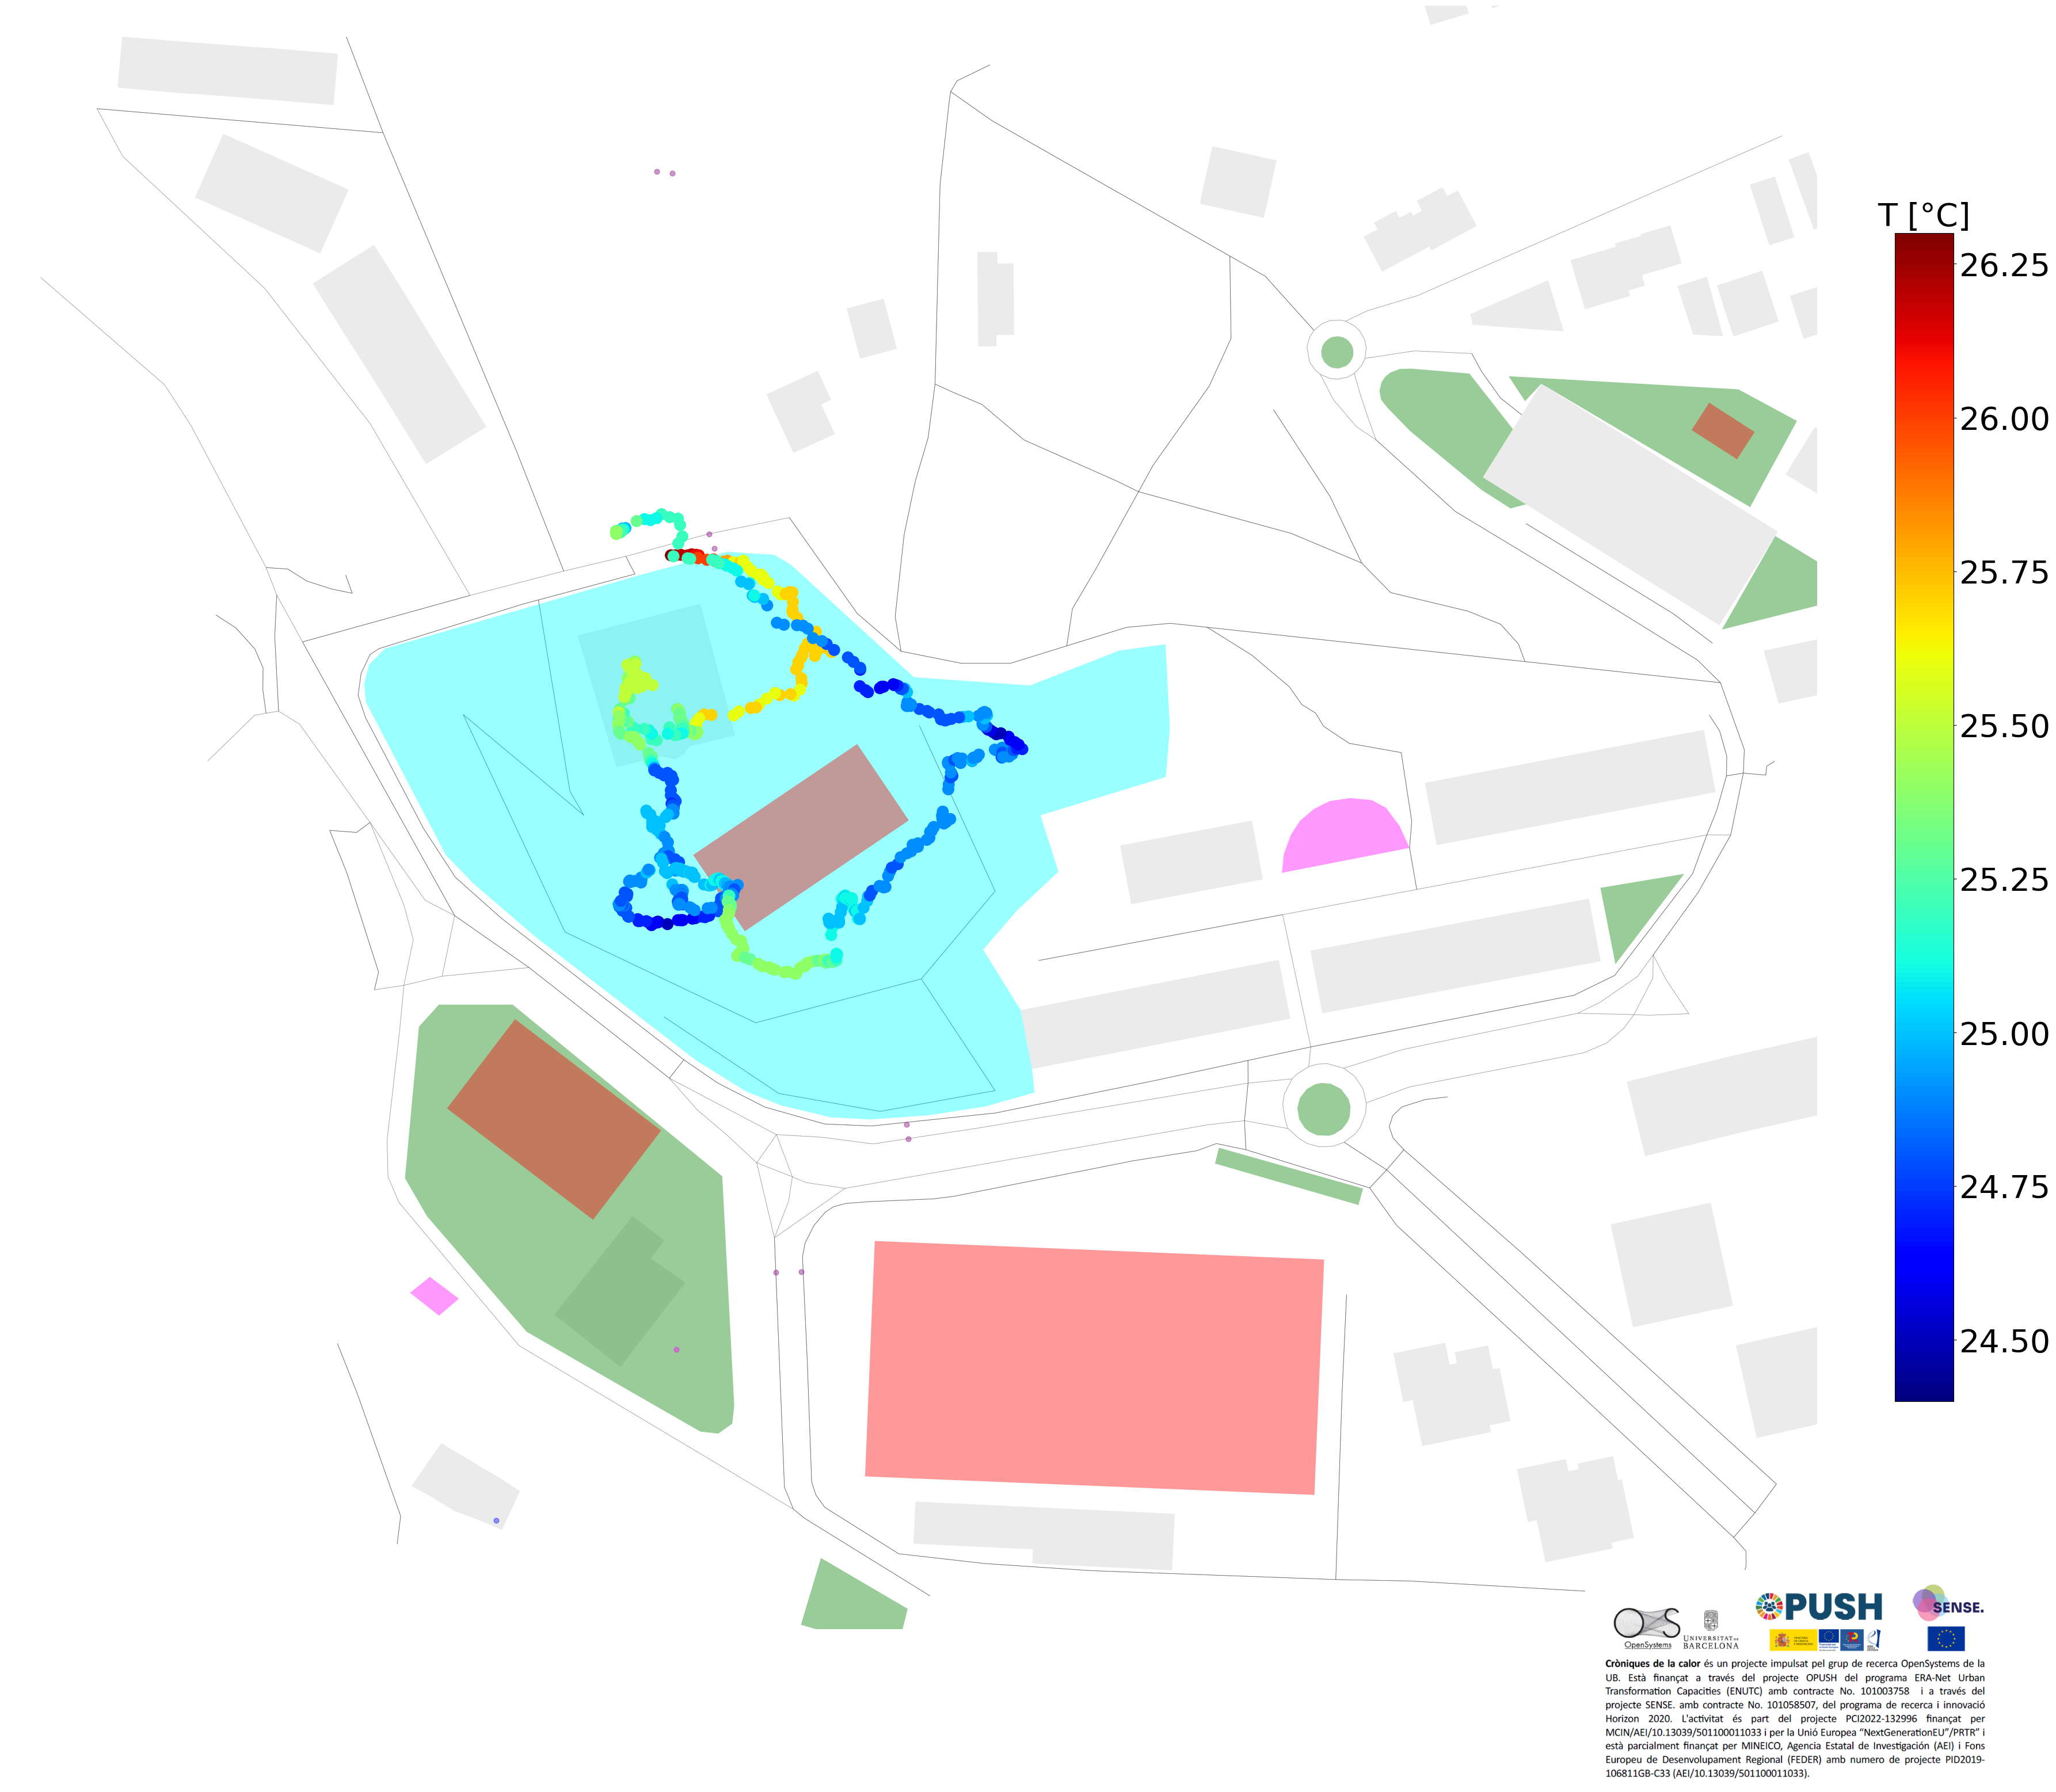

In [27]:
# Create the Map around La Guàrdia School
#P = Polygon([(1.995034,41.397762), (2.012427,41.397541),(2.012673,41.385776),(1.994998,41.385952)])  # Create the graph from lat and lon bounds

P = Polygon([(2.0019857,41.3935882),(2.0020072,41.3903525),(2.0067279,41.3903847),(2.0067816,41.3936123),(2.0019857,41.3935882)])  # Create the graph from lat and lon bounds

fig, ax = map_network_polygon(P)


# Plot Escola La Guàrdia
polygon_guardia = Polygon([(2.003915506266272, 41.391737084994254), (2.0043995628384583, 41.39196168135994), 
                             (2.0039522518688724, 41.392496064170196), (2.003339341173576, 41.39238114470467)])


#plot_polygon(ax, polygon_guardia, facecolor='lightblue', edgecolor='black')

#bbox_args = dict(boxstyle='square',facecolor='white', edgecolor='k',alpha=0.8)
#plt.annotate('Escola La Guàrdia', (2.003915506266272, 41.391737084994254),c='black',size=20,
                 #bbox=bbox_args, xytext=(5, -10),textcoords='offset points')



# Plot fountains
cm = 1/2.54
ax.scatter(df_fonts['LONGITUD'], df_fonts['LATITUD'],c='green', s=100*cm,alpha=0.5)
ax.scatter(df_fonts_ornamentals['LONGITUD'], df_fonts_ornamentals['LATITUD'],c='green', s=100*cm,alpha=0.5)


# Plot logos
from matplotlib.cbook import get_sample_data

im = plt.imread(get_sample_data('C:\\Users\\josep\\OneDrive - Universitat de Barcelona\\Escritorio\\mapes_calor\\1_mapes_tallers\\logos_new.png'))
newax = fig.add_axes([0.77, 0.03, 0.2, 0.2], anchor='SE')
newax.imshow(im)
newax.axis('off')


temp_JP= df_stvicenç_sessio1_JP['Temp[°C]'].tolist()
temp_FL=df_stvicenç_sessio1_FL['Temp[°C]'].tolist()

temp_FL_JP = temp_JP+temp_FL

cmap = mpl.cm.get_cmap('jet')
norm = mpl.colors.Normalize(min(temp_FL_JP), max(temp_FL_JP))
colors = cmap(norm(temp_JP))

ax.scatter(df_stvicenç_sessio1_JP['Lon'],df_stvicenç_sessio1_JP['Lat'], c=colors,s=500*cm)


sm =  ScalarMappable(norm=norm, cmap='jet')
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03,pad=0.04)
cbar.ax.set_title("T [°C]",fontsize=40)
cbar.ax.tick_params(labelsize=40)



plt.tight_layout()

#plt.savefig('guardia_heatmap_JP_session1.pdf',format='pdf')  # Save the figure in .pdf format


plt.show()

#### <u> SENSOR FL </u>

C:\Users\josep\AppData\Local\Temp\ipykernel_544\178938592.py:31: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\Users\\josep\\OneDrive - Universitat de Barcelona\\Escritorio\\mapes_calor\\1_mapes_tallers\\logos_new.png'>
  im = plt.imread(get_sample_data('C:\\Users\\josep\\OneDrive - Universitat de Barcelona\\Escritorio\\mapes_calor\\1_mapes_tallers\\logos_new.png'))
C:\Users\josep\AppData\Local\Temp\ipykernel_544\178938592.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('jet')
C:\Users\josep\AppData\Local\Temp\ipykernel_544\178938592.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


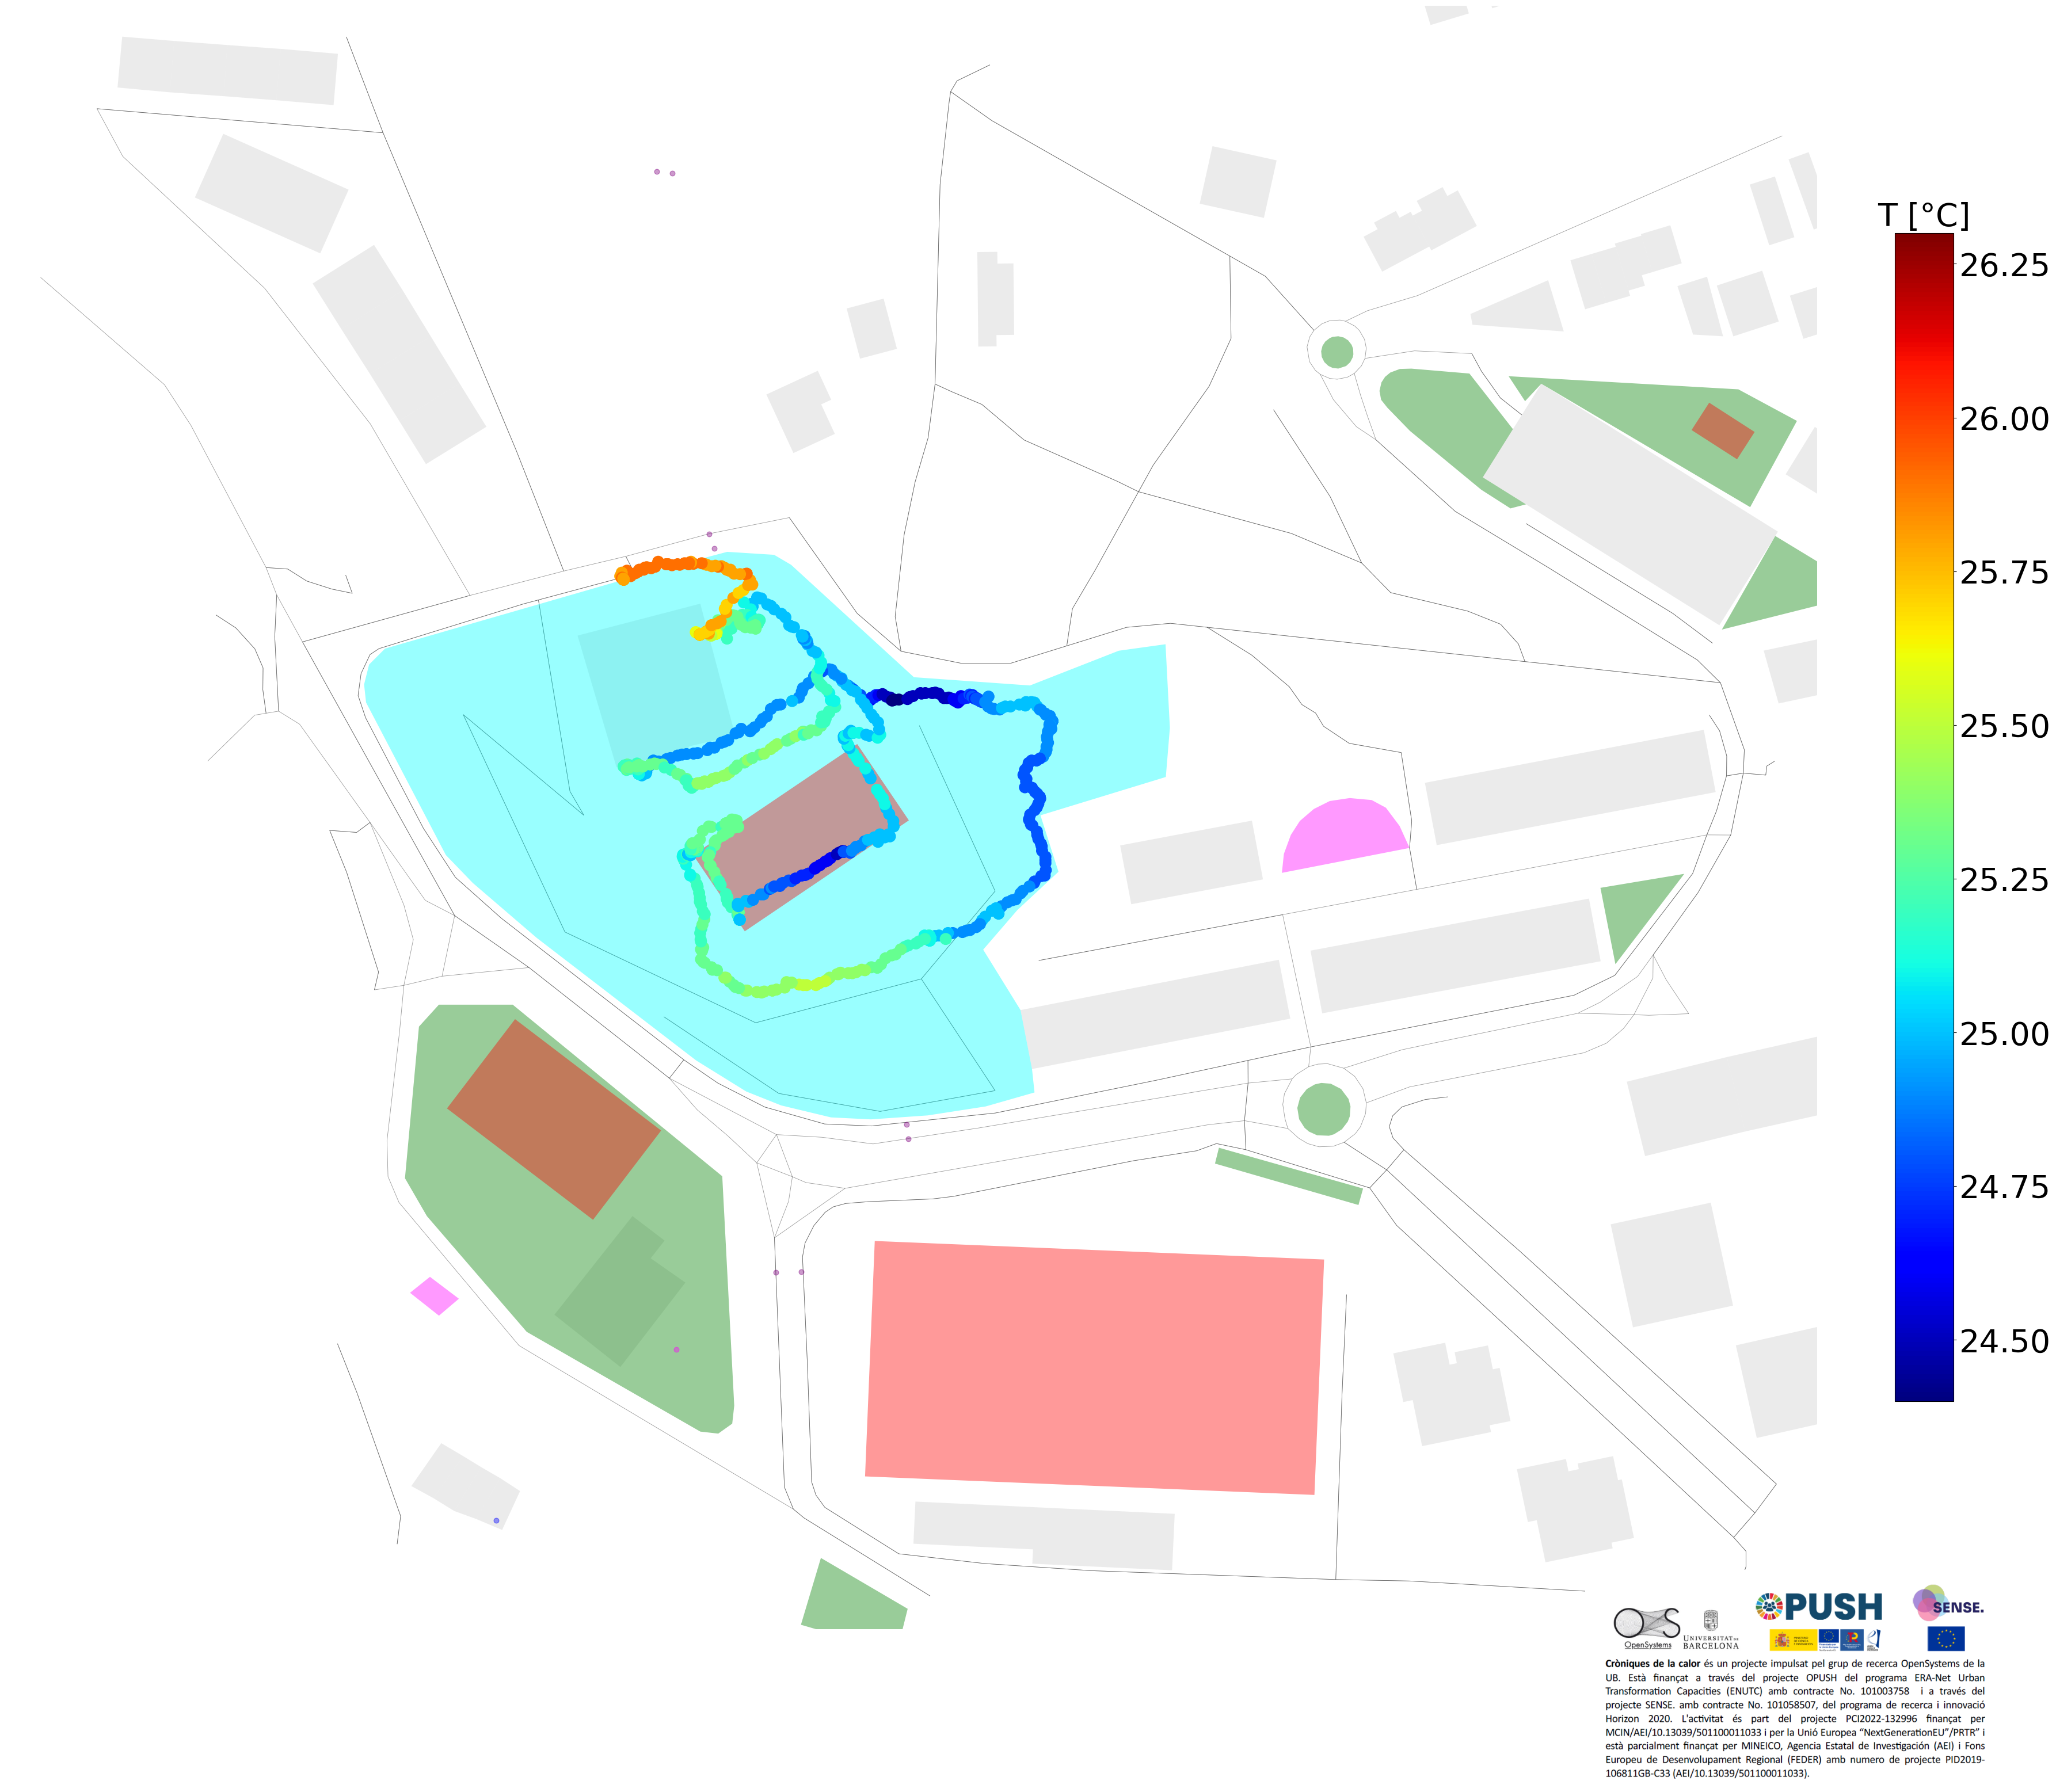

In [29]:
# Create the Map around La Guàrdia School
#P = Polygon([(1.995034,41.397762), (2.012427,41.397541),(2.012673,41.385776),(1.994998,41.385952)])  # Create the graph from lat and lon bounds

P = Polygon([(2.0019857,41.3935882),(2.0020072,41.3903525),(2.0067279,41.3903847),(2.0067816,41.3936123),(2.0019857,41.3935882)])  # Create the graph from lat and lon bounds

fig, ax = map_network_polygon(P)


# Plot Escola La Guàrdia
polygon_guardia = Polygon([(2.003915506266272, 41.391737084994254), (2.0043995628384583, 41.39196168135994), 
                             (2.0039522518688724, 41.392496064170196), (2.003339341173576, 41.39238114470467)])


#plot_polygon(ax, polygon_guardia, facecolor='lightblue', edgecolor='black')

#bbox_args = dict(boxstyle='square',facecolor='white', edgecolor='k',alpha=0.8)
#plt.annotate('Escola La Guàrdia', (2.003915506266272, 41.391737084994254),c='black',size=20,
                 #bbox=bbox_args, xytext=(5, -10),textcoords='offset points')



# Plot fountains
cm = 1/2.54
ax.scatter(df_fonts['LONGITUD'], df_fonts['LATITUD'],c='green', s=100*cm,alpha=0.5)
ax.scatter(df_fonts_ornamentals['LONGITUD'], df_fonts_ornamentals['LATITUD'],c='green', s=100*cm,alpha=0.5)


# Plot logos
from matplotlib.cbook import get_sample_data

im = plt.imread(get_sample_data('C:\\Users\\josep\\OneDrive - Universitat de Barcelona\\Escritorio\\mapes_calor\\1_mapes_tallers\\logos_new.png'))
newax = fig.add_axes([0.77, 0.03, 0.2, 0.2], anchor='SE')
newax.imshow(im)
newax.axis('off')


temp_JP= df_stvicenç_sessio1_JP['Temp[°C]'].tolist()
temp_FL=df_stvicenç_sessio1_FL['Temp[°C]'].tolist()

temp_FL_JP = temp_JP+temp_FL

cmap = mpl.cm.get_cmap('jet')
norm = mpl.colors.Normalize(min(temp_FL_JP), max(temp_FL_JP))
colors = cmap(norm(temp_FL))

ax.scatter(df_stvicenç_sessio1_FL['Lon'],df_stvicenç_sessio1_FL['Lat'], c=colors,s=500*cm)


sm =  ScalarMappable(norm=norm, cmap='jet')
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03,pad=0.04)
cbar.ax.set_title("T [°C]",fontsize=40)
cbar.ax.tick_params(labelsize=40)



plt.tight_layout()

#plt.savefig('guardia_heatmap_FL_session1.pdf',format='pdf')  # Save the figure in .pdf format


plt.show()